In [1]:
# https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling
# https://pypi.org/project/ChannelAttribution/

In [2]:
# !pip install --upgrade pip
# !pip install ChannelAttribution

In [3]:
%%capture

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px
import plotly.graph_objects as go
from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# Set the random seed for reproducibility
np.random.seed(1)

# Generate dummy data
n_rows = 250000
n_cookies = 100000
cookies = [f'{i:024x}' for i in np.random.randint(1, 1 << 48, n_cookies)]

# Define channels
# channels = ['Instagram', 'Online Display', 'Google Paid Search', 'Bing Paid Search', 'Email', 'Organic Search', 'Direct']
# channel_probs = [0.14, 0.19, 0.30, 0.07, 0.04, 0.08, 0.18]  # Uneven probabilities for channels

channels = [
    "Instagram",
    "Facebook",
    "Google Paid Search",
    "Bing Paid Search",
    "Twitter",
    "LinkedIn",
    "Pinterest",
    "Snapchat",
    "TikTok",
    "YouTube",
    "Online Display",
    "Email",
    "Organic Search",
    "Direct",
    "Affiliate Marketing",
    "Influencer Marketing",
    "Content Marketing",
    "SMS Marketing",
    "Podcast Advertising",
    "Referral Programs"
]
channel_probs = np.random.dirichlet(np.ones(20), size=1)[0]  # Generate random probabilities that sum to 1


# Generate data for each column
cookie_column = np.random.choice(cookies, n_rows)
channel_column = np.random.choice(channels, n_rows, p=channel_probs)
time_column = pd.to_datetime(np.random.randint(int(pd.Timestamp('2024-01-01').timestamp()), int(pd.Timestamp('2024-12-31').timestamp()), n_rows), unit='s')
conversions = np.random.choice([0, 1], n_rows, p=[0.9, 0.1])
conversion_values = conversions * np.round(np.random.uniform(10, 1000, n_rows), 2)


# Create DataFrame
data = {
    'cookie': cookie_column,
    'channel': channel_column,
    'time': time_column,
    'conversion': conversions,
    'conversion_value': conversion_values
}

df = pd.DataFrame(data)

# Sort by cookie and time
df = df.sort_values(by=['cookie', 'time'])

# Modify 'interaction' column to be either 'impression' or 'conversion'
df['interaction'] = df['conversion'].apply(lambda x: 'conversion' if x == 1 else 'impression')

# Show the first few rows
print(df.head())

# Save to a CSV file
df.to_csv('dummy_data.csv', index=False)

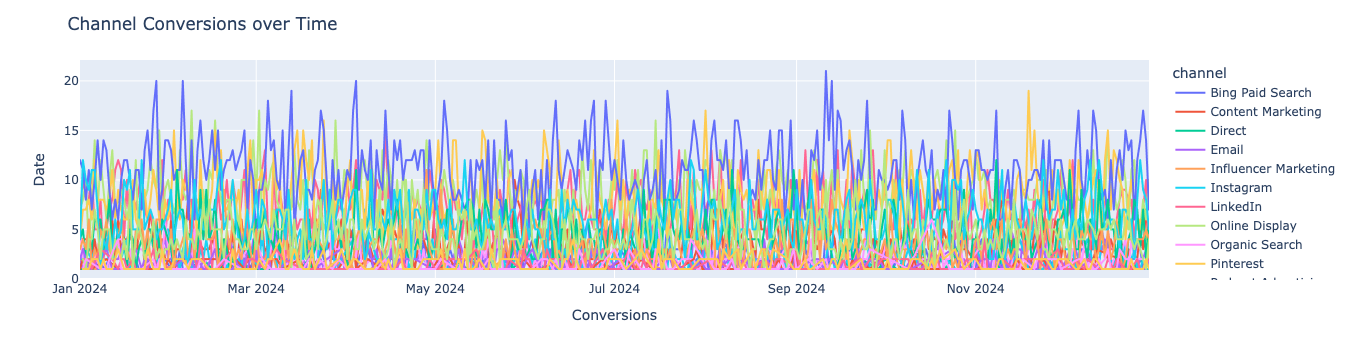

In [4]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time']< pd.to_datetime("2024-12-31").date()]
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()

In [5]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.head()

cookie              channel                time  \
165428  00000000000000012a58268b  Podcast Advertising 2024-03-28 08:36:36   
11522   00000000000000012a58268b              Twitter 2024-04-08 06:59:19   
182803  00000000000000012a58268b  Podcast Advertising 2024-05-06 13:00:07   
97298   00000000000000012a58268b              Twitter 2024-05-28 00:23:34   
211900  00000000000000012a58268b             LinkedIn 2024-06-11 01:00:32   

        conversion  conversion_value interaction  path_order  
165428           0               0.0  impression           1  
11522            0               0.0  impression           2  
182803           0               0.0  impression           3  
97298            0               0.0  impression           4  
211900           0               0.0  impression           5

In [6]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()

cookie                                               path
0  00000000000000012a58268b  [Podcast Advertising, Twitter, Podcast Adverti...
1  00000000000000020111c1c9          [SMS Marketing, Pinterest, SMS Marketing]
2  000000000000000398a26c33                                         [LinkedIn]
3  0000000000000003d02c2797                          [Online Display, Twitter]
4  0000000000000004d33cfe1f                         [Pinterest, SMS Marketing]

In [7]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

cookie  conversion  conversion_value
137637  00000000000000012a58268b           0               0.0
37679   00000000000000020111c1c9           0               0.0
104713  000000000000000398a26c33           0               0.0
99895   0000000000000003d02c2797           0               0.0
100271  0000000000000004d33cfe1f           0               0.0

In [8]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

cookie  \
0  00000000000000012a58268b   
1  00000000000000020111c1c9   
2  000000000000000398a26c33   
3  0000000000000003d02c2797   
4  0000000000000004d33cfe1f   

                                                path  conversion  \
0  [Podcast Advertising, Twitter, Podcast Adverti...           0   
1          [SMS Marketing, Pinterest, SMS Marketing]           0   
2                                         [LinkedIn]           0   
3                          [Online Display, Twitter]           0   
4                         [Pinterest, SMS Marketing]           0   

   conversion_value  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [9]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 24933
Total conversion rate: 10%
Total value of conversions: $12694797
Average conversion value: $509


In [10]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

cookie  \
0  00000000000000012a58268b   
1  00000000000000020111c1c9   
2  000000000000000398a26c33   
3  0000000000000003d02c2797   
4  0000000000000004d33cfe1f   

                                                path  conversion  \
0  Podcast Advertising > Twitter > Podcast Advert...           0   
1          SMS Marketing > Pinterest > SMS Marketing           0   
2                                           LinkedIn           0   
3                           Online Display > Twitter           0   
4                          Pinterest > SMS Marketing           0   

   conversion_value  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [11]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.to_csv('ordered_data.csv', index=False)

attribution_df.sample(10)

path  total_conversions  \
23904              Twitter > Referral Programs > Twitter                  0   
21582  TikTok > Online Display > Twitter > SMS Marketing                  0   
3805   Facebook > Content Marketing > Content Marketi...                  1   
6224   Instagram > Organic Search > Pinterest > Linke...                  0   
5818   Influencer Marketing > Twitter > Facebook > Af...                  0   
651    Bing Paid Search > Facebook > Pinterest > Emai...                  0   
4119   Facebook > Instagram > Online Display > Online...                  0   
6376   Instagram > Podcast Advertising > Pinterest > ...                  0   
12969    Pinterest > Facebook > Organic Search > Twitter                  0   
20766                               Snapchat > Pinterest                  6   

       total_conversion_value  total_null  
23904                    0.00           2  
21582                    0.00           1  
3805                   107.13           0  
6224                     0.00           1  
5818                     0.00           1  
651                      0.00           1  
4119                     0.00           1  
6376                     0.00           1  
12969                    0.00           1  
20766                 3316.12          25

In [12]:
#Now, we will use the ChannelAttribution package to create the attribution models described above

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 2.02% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.73%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


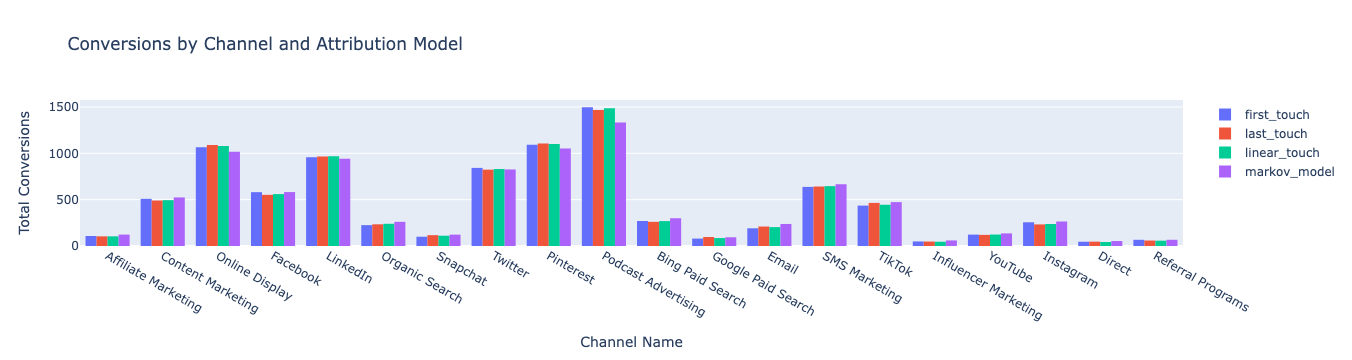

In [13]:
# Merge dataframes H and M
R = pd.merge(H, M, on="channel_name", how="inner")

# Select and rename columns
R1 = R[["channel_name", "first_touch_conversions", "last_touch_conversions",
        "linear_touch_conversions", "total_conversions"]]
R1.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

# Melt the dataframe
R1 = pd.melt(R1, id_vars="channel_name")

# Create the histogram
fig = go.Figure()

# Add traces for each conversion type
for conversion_type in R1['variable'].unique():
    df_filtered = R1[R1['variable'] == conversion_type]
    fig.add_trace(go.Histogram(
        x=df_filtered['channel_name'],
        y=df_filtered['value'],
        name=conversion_type,
        histfunc='sum'
    ))

# Update layout
fig.update_layout(
    title='Conversions by Channel and Attribution Model',
    xaxis_title='Channel Name',
    yaxis_title='Total Conversions',
    barmode='group'
)

# Show the figure
fig.show()

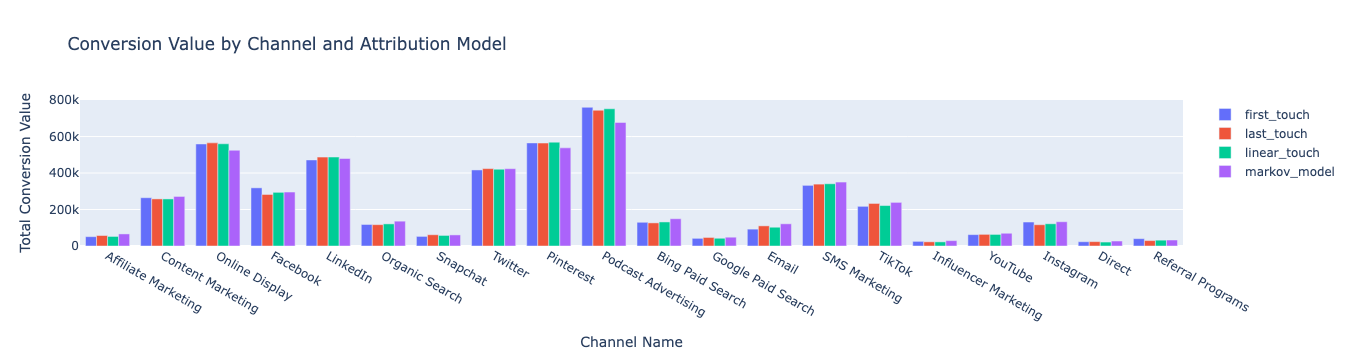

In [14]:
# Select and rename columns
R2 = R[["channel_name", "first_touch_value", "last_touch_value",
        "linear_touch_value", "total_conversion_value"]]
R2.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

# Melt the dataframe
R2 = pd.melt(R2, id_vars="channel_name")

# Create the barchart
fig = go.Figure()

# Add traces for each conversion value type
for value_type in R2['variable'].unique():
    df_filtered = R2[R2['variable'] == value_type]
    fig.add_trace(go.Bar(
        x=df_filtered['channel_name'],
        y=df_filtered['value'],
        name=value_type
    ))

# Update layout
fig.update_layout(
    title='Conversion Value by Channel and Attribution Model',
    xaxis_title='Channel Name',
    yaxis_title='Total Conversion Value',
    barmode='group'  # Set to 'group' to display bars next to each other
)

# Show the figure
fig.show()

In [15]:
R = R.rename(columns={'total_conversions':'markov_model_conversions', 'total_conversion_value':'markov_model_value'})
R['M_LT_Change'] = R['markov_model_conversions'] / R['last_touch_conversions'] - 1
R['M_LT_Change_Net'] = R['markov_model_conversions'] - R['last_touch_conversions']
R = R.round(2)

R.to_csv('dda_output.csv', index=False)
R[:]

channel_name  first_touch_conversions  first_touch_value  \
0    Affiliate Marketing                    108.0           51169.55   
1      Content Marketing                    509.0          264687.89   
2         Online Display                   1065.0          559331.08   
3               Facebook                    581.0          318823.70   
4               LinkedIn                    957.0          471802.17   
5         Organic Search                    225.0          118033.57   
6               Snapchat                    100.0           52606.78   
7                Twitter                    843.0          416889.74   
8              Pinterest                   1092.0          565082.44   
9    Podcast Advertising                   1497.0          760320.39   
10      Bing Paid Search                    270.0          130050.70   
11    Google Paid Search                     80.0           41980.57   
12                 Email                    191.0           92465.66   
13         SMS Marketing                    638.0          332399.64   
14                TikTok                    436.0          217436.70   
15  Influencer Marketing                     49.0           25409.49   
16               YouTube                    123.0           62377.75   
17             Instagram                    256.0          131403.00   
18                Direct                     46.0           23388.74   
19     Referral Programs                     67.0           40166.01   

    last_touch_conversions  last_touch_value  linear_touch_conversions  \
0                    104.0          57545.37                    104.22   
1                    491.0         258194.64                    494.73   
2                   1091.0         565336.66                   1079.49   
3                    552.0         282456.18                    560.09   
4                    965.0         487258.76                    968.32   
5                    234.0         116938.95                    239.83   
6                    117.0          61739.90                    111.01   
7                    824.0         424421.64                    830.50   
8                   1105.0         564386.07                   1100.82   
9                   1468.0         744076.65                   1486.35   
10                   261.0         126687.29                    268.78   
11                    97.0          46873.31                     85.56   
12                   210.0         110326.91                    203.77   
13                   642.0         339216.47                    646.00   
14                   465.0         233254.53                    445.19   
15                    48.0          22959.20                     46.10   
16                   120.0          63858.13                    123.70   
17                   233.0         116592.87                    237.46   
18                    47.0          24005.38                     43.53   
19                    59.0          29696.66                     57.54   

    linear_touch_value  markov_model_conversions  markov_model_value  \
0             52406.00                    123.23            66209.37   
1            258032.70                    524.11           271693.05   
2            560293.48                   1016.25           524909.33   
3            294181.84                    581.83           295836.91   
4            487726.77                    940.60           479683.62   
5            121264.45                    260.89           136165.42   
6             57927.30                    122.45            60775.93   
7            420796.90                    825.95           423828.59   
8            569279.58                   1051.35           537909.58   
9            752200.91                   1334.07           677192.38   
10           131859.07                    299.49           149522.30   
11            42402.50                     93.98            48224.60   
12      

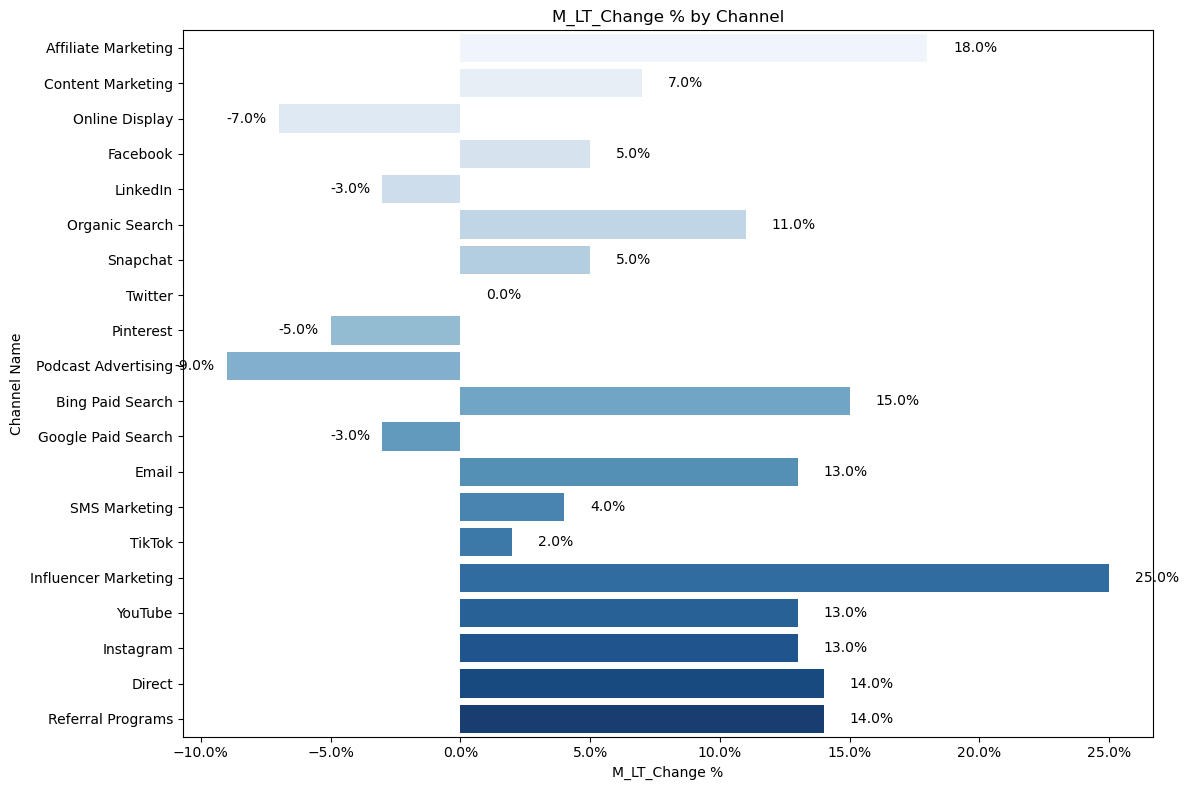

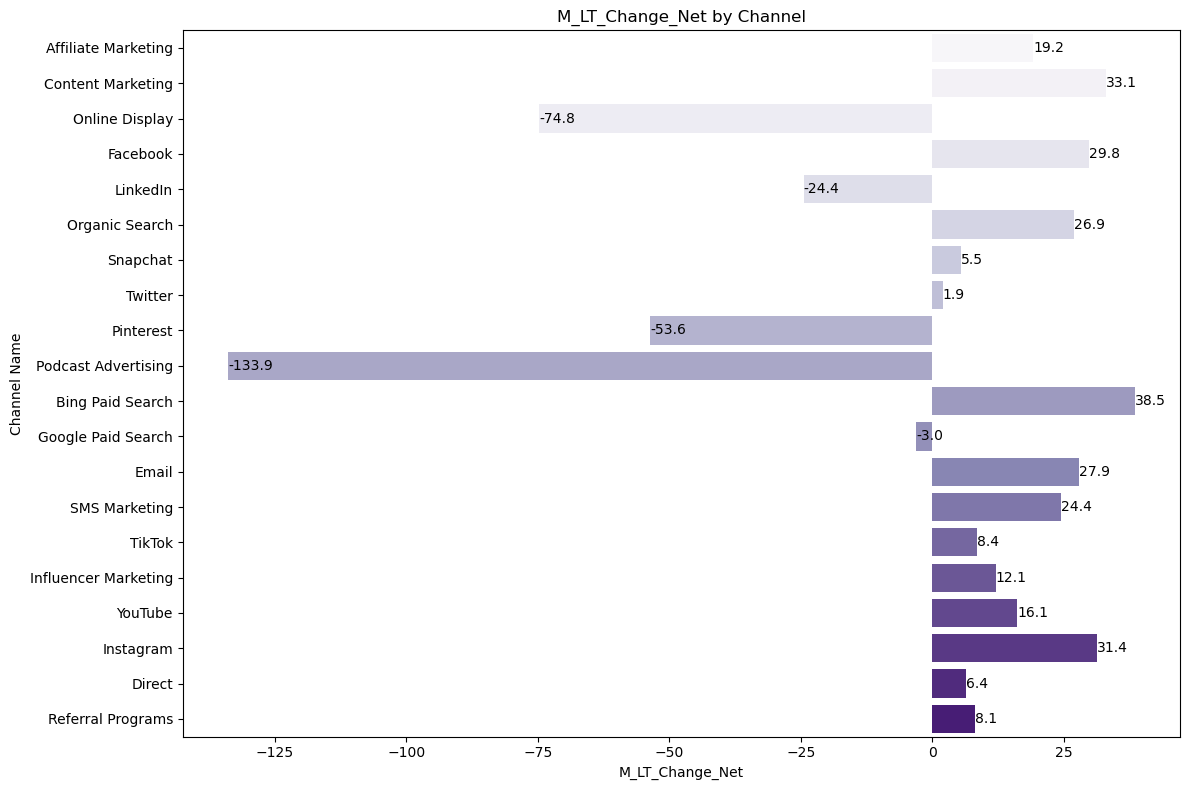

In [16]:
columns = [
    ('M_LT_Change', 'M_LT_Change % by Channel', 'M_LT_Change %', 'Blues'),
    ('M_LT_Change_Net', 'M_LT_Change_Net by Channel', 'M_LT_Change_Net', 'Purples')
]

for column, title, xlabel, palette in columns:
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    ax = sns.barplot(x=column, y='channel_name', data=R, palette=palette)
    
    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Channel Name')
    
    # Format x-axis as percentage if dealing with 'M_LT_Change'
    if column == 'M_LT_Change':
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        # Add data labels as percentages
        for index, value in enumerate(R[column]):
            ax.text(value + 0.01 if value >= 0 else value - 0.02, index, f'{value:.1%}', color='black', va="center")
    else:
        # Add data labels as numbers
        for index, value in enumerate(R[column]):
            ax.text(value + 0.01 if value >= 0 else value - 0.02, index, f'{value:.1f}', color='black', va="center")
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [17]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [18]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)
matrix.rename(columns={'(null)':'No Conv'}, inplace=True)

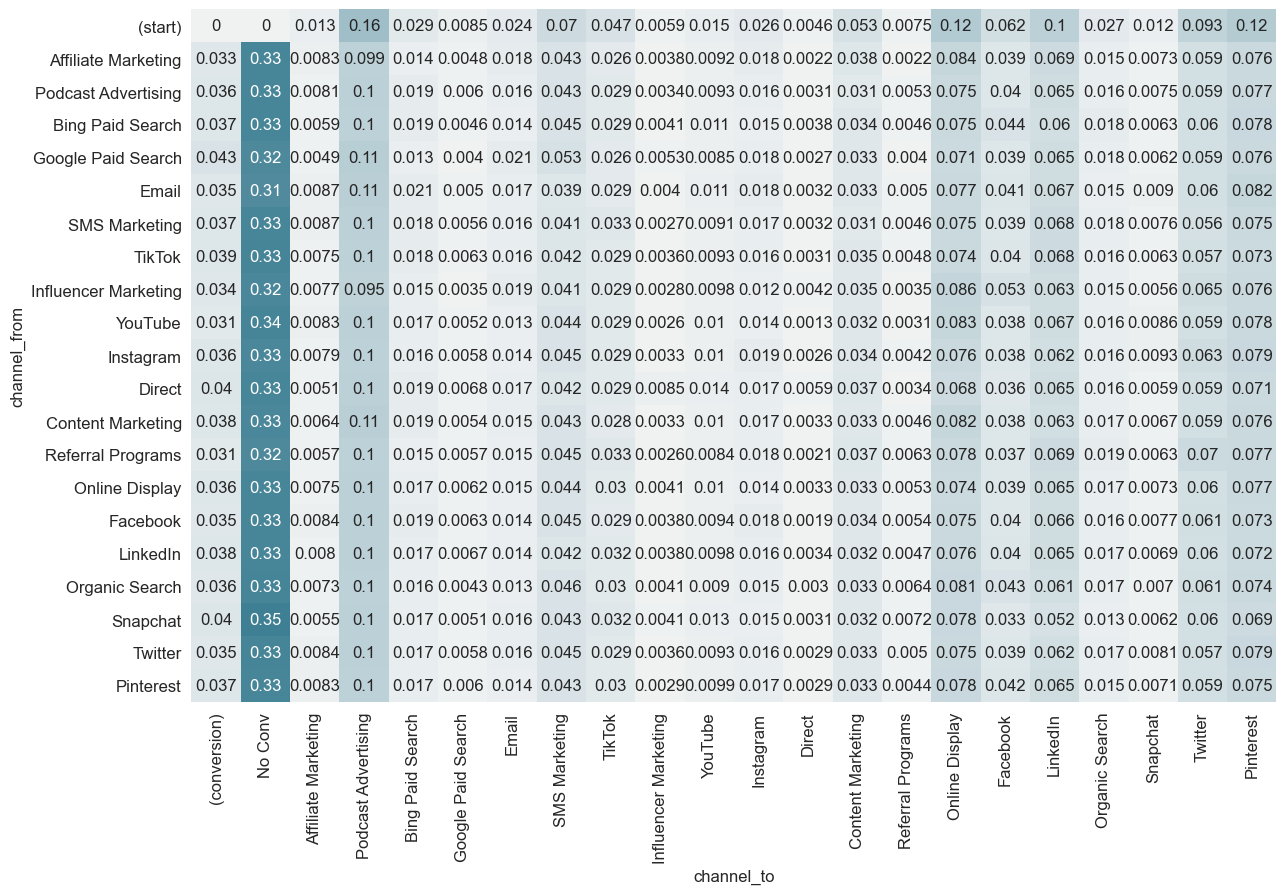

In [19]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

fig.savefig('heatmap_output.png')